<h1>Movie Genius!</h1>

<h3>Load Raw Data

In [1]:
%run data_preprocessing.ipynb

<h3>Data preprocessing

In [2]:
movies.head(1)

,title,genres,cast,director,keywords,budget,revenue,vote_count,rating
0,Avatar,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron,"['culture clash', 'future', 'space war', 'spac...",237000000,2787965087,11800,7.2


<h3>Feature Exraction

In [18]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

m = movies.dropna()

for col in ['genres', 'cast', 'director', 'keywords']:
    m[col] = m[col].str.split(',').apply(lambda x: [i.strip('[]') for i in x])

columns_to_process = ['genres', 'cast', 'director', 'keywords']

mlb = MultiLabelBinarizer()

for column in columns_to_process:
    m = m.join(pd.DataFrame(mlb.fit_transform(m.pop(column)),
                                      columns=[f"{column}_{class_}" for class_ in mlb.classes_],
                                      index=m.index))

In [19]:
m.head(1)

,title,budget,revenue,vote_count,rating,genres_ 'Action',genres_ 'Adventure',genres_ 'Animation',genres_ 'Comedy',genres_ 'Crime',...,keywords_'wrestling',keywords_'writing',keywords_'wyoming',keywords_'yacht',keywords_'yakuza',keywords_'yorkshire',keywords_'yuppie',keywords_'zombie',keywords_'zoo',keywords_'绝地奶霸'
0,Avatar,237000000,2787965087,11800,7.2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Splitting into train and test sets

In [20]:
y = m['rating']
X = m.drop(columns = ['rating', 'title'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
y.head(1)

0    7.2
Name: rating, dtype: float64

In [22]:
X.head(1)

,budget,revenue,vote_count,genres_ 'Action',genres_ 'Adventure',genres_ 'Animation',genres_ 'Comedy',genres_ 'Crime',genres_ 'Documentary',genres_ 'Drama',...,keywords_'wrestling',keywords_'writing',keywords_'wyoming',keywords_'yacht',keywords_'yakuza',keywords_'yorkshire',keywords_'yuppie',keywords_'zombie',keywords_'zoo',keywords_'绝地奶霸'
0,237000000,2787965087,11800,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Supervised Learning

<h4>For movie recommendations with KNN

In [23]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(X_train)

def recommend_movies(x=0):
    # Get the top 10 nearest neighbors for the movie
    distances, indices = model_knn.kneighbors(X_train[x, :].reshape(1, -1), n_neighbors = 11)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print(f"Recommendations for {m['title'].iloc[x]}:\n")
        else:
            print(f"{i}: {m['title'].iloc[indices.flatten()[i]]}, with distance of {round(distances.flatten()[i], 7)}")

recommend_movies()

Recommendations for Avatar:

1: Megaforce, with distance of 0.9588232
2: Think Like a Man, with distance of 0.9596972
3: Tomorrowland, with distance of 0.9615161
4: Snow White: A Tale of Terror, with distance of 0.9616133
5: A Knight's Tale, with distance of 0.9619494
6: Back to the Future Part II, with distance of 0.965907
7: Listening, with distance of 0.9680489
8: The Other Side of Heaven, with distance of 0.9703366
9: Winter's Tale, with distance of 0.9711424
10: Shine, with distance of 0.9783111


<h3>For rating prediction

Import all machine learning tools and functions required

For KNN

In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

#predict a movie rating
def predict_rating(i=0, model=knn, y_test = y_test):
    # Predict the response for test dataset
    y_pred = model.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # Extract the features for the specified index
    movie_features = X_test[i, :].reshape(1, -1)
    predicted_rating = model.predict(movie_features)
    actual_rating = m['rating'][i]
    print(f"For {model}:")
    print(f"\nPredicted rating for the movie {m['title'][i]} is {predicted_rating[0]:.2f}")
    print(f"Actual Rating for the movie {m['title'][i]} is {actual_rating:.2f}")
    print(f'\nWith a mean squared error of {mse:.2f} and mean absolute error of {mae:.2f}')

predict_rating()

For KNeighborsRegressor():

Predicted rating for the movie Avatar is 6.16
Actual Rating for the movie Avatar is 7.20

With a mean squared error of 0.93 and mean absolute error of 0.76


In [27]:
#import libraries
from sklearn.model_selection import cross_val_score

y_pred = knn.predict(X_test)
y_test = pd.DataFrame(y_test).values.flatten()

cv_r2 = cross_val_score(knn, X, y, cv=10, scoring='r2').mean()
cv_mse = cross_val_score(knn, X, y, cv=10, scoring='neg_mean_squared_error').mean()

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('KNN Model Ratings Prediction for All Movies')

#regression line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')

#add the legends with the cross-validated r-square and mse
plt.legend([f'CV R2 = {cv_r2:.2f}', f'CV MSE = {cv_mse:.2f}'], loc='best')

plt.show()

For Random forest

In [ ]:
#rf_regressor
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(X_train, y_train)

predict_rating(model=rf_regressor)

In [ ]:
y_pred = rf_regressor.predict(X_test)
y_test = pd.DataFrame(y_test).values.flatten()

cv_r2 = cross_val_score(rf_regressor, X, y, cv=10, scoring='r2').mean()
cv_mse = cross_val_score(rf_regressor, X, y, cv=10, scoring='neg_mean_squared_error').mean()

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('RF Model Ratings Prediction for All Movies')

#regression line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')

#add the legends with the cross-validated r-square and mse
plt.legend([f'CV R2 = {cv_r2:.2f}', f'CV MSE = {cv_mse:.2f}'], loc='best')

plt.show()

For SVM

In [ ]:
#svm_regressor
svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train, y_train)

predict_rating(model=svm_regressor)

In [ ]:
y_pred = svm_regressor.predict(X_test)
y_test = pd.DataFrame(y_test).values.flatten()

cv_r2 = cross_val_score(svm_regressor, X, y, cv=10, scoring='r2').mean()
cv_mse = cross_val_score(svm_regressor, X, y, cv=10, scoring='neg_mean_squared_error').mean()

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('SVM Ratings Prediction for All Movies')

#regression line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')

#add the legends with the cross-validated r-square and mse
plt.legend([f'CV R2 = {cv_r2:.2f}', f'CV MSE = {cv_mse:.2f}'], loc='best')

plt.show()

For Linear regression

In [ ]:
#linear_model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

predict_rating(model=linear_model)

In [ ]:
y_pred = linear_model.predict(X_test)
y_test = pd.DataFrame(y_test).values.flatten()

cv_r2 = cross_val_score(linear_model, X, y, cv=10, scoring='r2').mean()
cv_mse = cross_val_score(linear_model, X, y, cv=10, scoring='neg_mean_squared_error').mean()

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Linear Model Ratings Prediction for All Movies')

#regression line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')

#add the legends with the cross-validated r-square and mse
plt.legend([f'CV R2 = {cv_r2:.2f}', f'CV MSE = {cv_mse:.2f}'], loc='best')

plt.show()

For Ridge regression

In [ ]:
#ridge_model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

predict_rating(model=ridge_model)

In [ ]:
y_pred = ridge_model.predict(X_test)
y_test = pd.DataFrame(y_test).values.flatten()

cv_r2 = cross_val_score(ridge_model, X, y, cv=10, scoring='r2').mean()
cv_mse = cross_val_score(ridge_model, X, y, cv=10, scoring='neg_mean_squared_error').mean()

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Ridge Model Ratings Prediction for All Movies')

#regression line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')

#add the legends with the cross-validated r-square and mse
plt.legend([f'CV R2 = {cv_r2:.2f}', f'CV MSE = {cv_mse:.2f}'], loc='best')

plt.show()

For Lasso regression

In [ ]:
#lasso_model
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

predict_rating(model=lasso_model)

In [ ]:
y_pred = lasso_model.predict(X_test)
y_test = pd.DataFrame(y_test).values.flatten()

cv_r2 = cross_val_score(lasso_model, X, y, cv=10, scoring='r2').mean()
cv_mse = cross_val_score(lasso_model, X, y, cv=10, scoring='neg_mean_squared_error').mean()

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Lasso Model Ratings Prediction for All Movies')

#regression line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')

#add the legends with the cross-validated r-square and mse
plt.legend([f'CV R2 = {cv_r2:.2f}', f'CV MSE = {cv_mse:.2f}'], loc='best')

plt.show()

Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

models = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'SVM': SVR(kernel='linear'),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0)
}

# Perform k-fold cross-validation for each model
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)

for model_name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=k_fold, scoring='neg_mean_squared_error')
    mse_cv = -cv_scores.mean()
    print(f'Cross-Validated MSE for {model_name}: {mse_cv:.2f}')


<h3>Unsupervised Learning</h3>

For K-means clustering

In [68]:
#Kmeans clustering
from sklearn.cluster import KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=1)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataset
data_with_clusters = pd.concat([pd.DataFrame(X), pd.Series(cluster_labels, name='Cluster')], axis=1)
grouped_clusters = data_with_clusters.groupby('Cluster').mean()

print(grouped_clusters)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


               budget       revenue   vote_count  genres_ 'Action'  \
Cluster                                                              
0.0      3.367455e+07  9.618942e+07   801.419036          0.090235   
1.0      1.000000e+07  2.995811e+06   254.000000          0.000000   
2.0      5.600000e+07  1.420446e+08   718.000000          0.000000   
3.0      0.000000e+00  0.000000e+00    10.000000          0.000000   
4.0      2.500000e+08  7.478628e+08  6032.000000          0.000000   

         genres_ 'Adventure'  genres_ 'Animation'  genres_ 'Comedy'  \
Cluster                                                               
0.0                 0.106551             0.025711          0.143881   
1.0                 0.000000             0.000000          0.000000   
2.0                 0.000000             0.000000          0.000000   
3.0                 0.000000             0.000000          0.000000   
4.0                 1.000000             0.000000          0.000000   

         ge

Graphical visualization

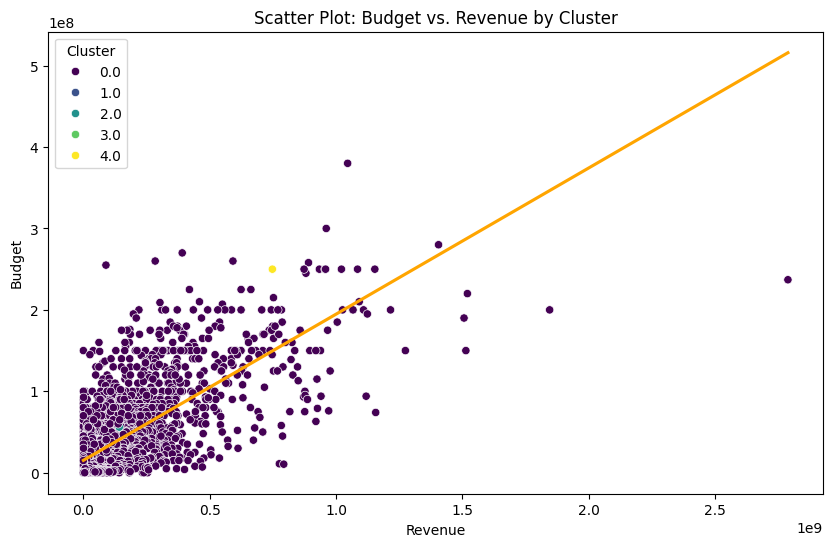

In [69]:
import seaborn as sns

# Scatter plot for budget vs. revenue colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='revenue', y='budget', hue='Cluster', data=data_with_clusters, palette='viridis', hue_order=[0.0, 1.0, 2.0, 3.0, 4.0])
sns.regplot(x='revenue', y='budget', data=data_with_clusters, scatter=False, ci=None, color='orange')
plt.title('Scatter Plot: Budget vs. Revenue by Cluster')
plt.xlabel('Revenue')
plt.ylabel('Budget')
plt.show()